# PyDesigner Example
This notebook serves to educate on PyDesigner and it's usage. Currently, this example will only cover portions past preprocessing for stability testing of **dwipi**.

## Load Modules
Start by loading modules necessary to execute this script

In [1]:
import nibabel as nib
import numpy as np
from fitting import dwipi as dp
import matplotlib.pyplot as plt
import time
import os

## Load Paths
First define paths - to read and save images. There are primarily two paths defined for testing:
1. `niiPath`: path to preprocessed NifTi file
2. `outDir`:  output directory where maps will be saved

In [2]:
niiPath = '/Users/sid/Downloads/nii_test/DWI/PARAMAPS/dwi_designer.nii'
savePath = '/Users/sid/Downloads/PyDesigner_Test'

## Create DWI Class
The `DWI` class holds information on the NifTi image. Initialize is done by loading the image and it's dependencies to memory. These attributes are:

1. **img**: The diffusuion weighted image (DWI) itself
2. **grad**:Gradient table with 4 columns [X, Y, Z, B-Value]
4. **hdr**: NifTI header information
5. **mask**: Brain mask
6. **maskStatus**: Mask status indicating whether a brain mask is present or not

Additional attributes will be added to this class depending on the method being called. For example, running class.fit() create a class.dt attribute within the DWI class.

### Why so classy?
Classes allow complete isolation of an image and it's primary attributes. This is helpful when processing multiple DWIs for comparison. You can create as many DWI class objects as you wish and still keep track of all esential parameters making up those DWI.

### Onto making DWI class
Let's start by craeting our first DWI class object. We previously defined a path to a NifTi file, let's use this to load a DWI class object. We can then print this class' attributes to demonstrate the information it's currently holding.

In [3]:
myimage = dp.DWI(niiPath)
print(myimage.__dict__.keys())

Image dwi_designer.nii loaded successfully
Processing with 16 workers...
dict_keys(['hdr', 'img', 'grad', 'mask', 'maskStatus', 'workers'])


Just to be safe, let's also plot the raw DWI images just to prove that they have indeed been loaded into memory ;)

(-0.5, 109.5, 109.5, -0.5)

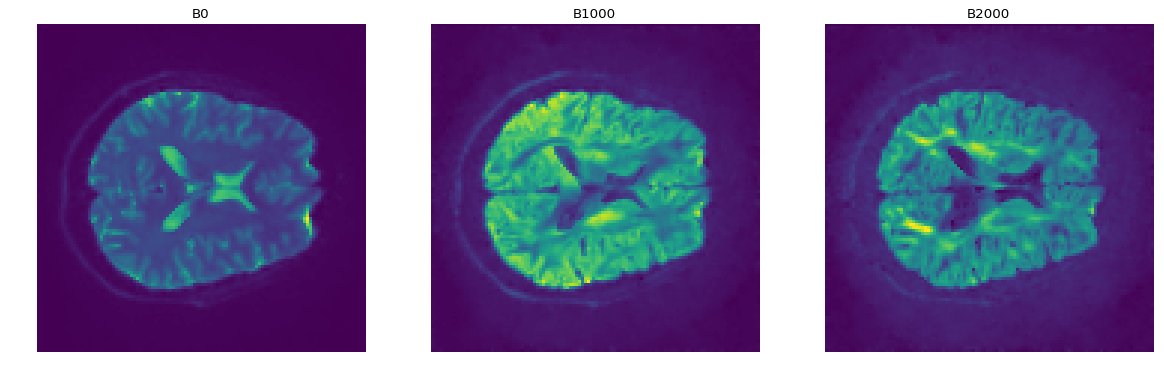

In [4]:
fig = plt.figure(figsize=(18, 16), dpi= 80)
img1 = fig.add_subplot(1,3,1)
img1.imshow(myimage.img[:,:,30,0])    # Plot first volume, slice 30 (B0)
img1.title.set_text('B0')
img1.axis('off')
img2 = fig.add_subplot(1,3,2)
img2.imshow(myimage.img[:,:,30,10])   # Plot 10th volume, slice 30 (B1000)
img2.title.set_text('B1000')
img2.axis('off')
img3 = fig.add_subplot(1,3,3)
img3.imshow(myimage.img[:,:,30,100])  # Plot 100th volume, slice 30 (B2000)
img3.title.set_text('B2000')
img3.axis('off')

**Amazing!!!**

## Fitting Sequence
The ideal fitting sequence should minimize the effects of noise on tensor estimation. We do this by first computing the IRLLS outliers, followed by constrained tensor estimation by excluding outliers. This can be done quite simply given the class object. Watch and learn.

### Outlier Detection with Iterative Reweighted Linear Least Squares (IRLLS)
This is a method of computing iteratively optimizing a tensor until a convergence point is reaced. The good-of-fit (GOF) is then tested and voxels that deviate far from GOF are marked as outliers. These voxels manipulate the accuracy of tensor estimation and thus are excluded from constrained tensor fitting.

Running IRLLS is as simple as calling `myimage.irlls()`. Default values have been optimized so absolutely no input is required. Easy as that!

In [5]:
outliers, dt_hat = myimage.irlls()    # Produce 4D outlier map

IRLLS: Outlier Detection: 100%|█| 187039/187039 [01:20<00:00, 2315.89vox/s]


That was easy, wasn't it? Let's take a look at some of these outliers.

(-0.5, 109.5, 109.5, -0.5)

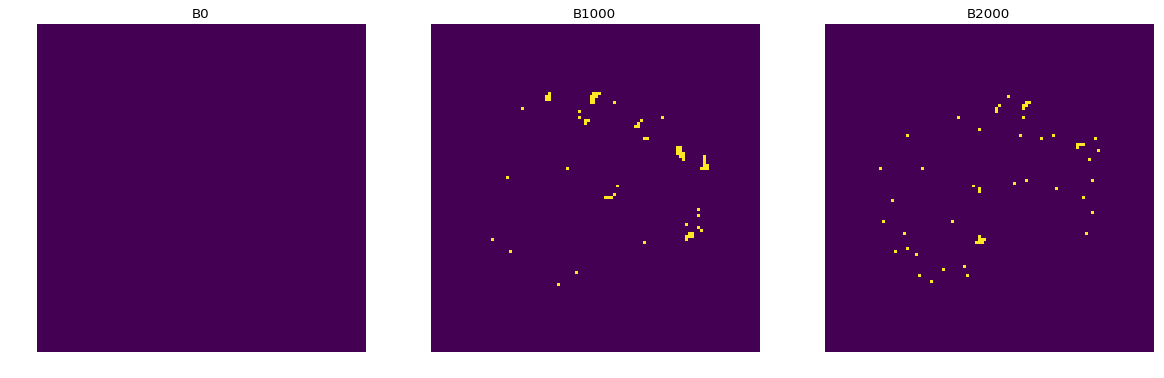

In [6]:
fig = plt.figure(figsize=(18, 16), dpi= 80)
img1 = fig.add_subplot(1,3,1)
img1.imshow(outliers[:,:,30,0])       # Plot first volume, slice 30 (B0)
img1.title.set_text('B0')
img1.axis('off')
img2 = fig.add_subplot(1,3,2)
img2.imshow(outliers[:,:,30,10])      # Plot 10th volume, slice 30 (B1000)
img2.title.set_text('B1000')
img2.axis('off')
img3 = fig.add_subplot(1,3,3)
img3.imshow(outliers[:,:,30,100])     # Plot 100th volume, slice 30 (B2000)
img3.title.set_text('B2000')
img3.axis('off')

These plots show voxels that are outliers on the same volumes and sliices as the previous figure. These outlier voxels are not used in the estimation of diffusion tensor to maintain accuracy.

### Tensor Estimation
Now that you witnessed how easy it is to run this pipeline, let's do the same for tensor estimation. This is done using `myimage.fit()`. Easy enough? Sure! by default, providing no inputs performs unconstrained tensor fitting without outlier exclusion. However, constraining is as easy as providing as constraint vector, while outlier exclusion can be performed by providing the outlier map. Let's get to it!

Take not, this is one of the class methods that adds essential class attributes for further computations.

In [7]:
myimage.fit(constraints=[0,1,0], reject=outliers)

Constrained Tensor Fit  :   9%| | 17435/187039 [00:04<00:34, 4899.71vox/s]/Users/sid/miniconda3/envs/deep/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
Constrained Tensor Fit  : 100%|█| 187039/187039 [00:45<00:00, 4153.27vox/s]


Now, let's print the all attributes withing the DWI class to see what else has been added.

In [8]:
# print(myimage.__dict__.keys())

Running tensor estimation has added three additional attributes:
1. **b**: not sure at the moment :S
2. **dt**: the ketchup to my steak, diffusion tensor
3. **s0**: signal intensity for B0

The addition of these attributes allow further caluculations to take palce within the DWI class object itself, thereby maintain isolation.

### View Tensors
Let's take a look at some of these tensors. The `DWI` object contains a `reorderTensor(imgType)` method that outputs diffusion or kurtosis tensors in MRTRIX3's format, depending on the parameter provided.

In addition, detection of whether an image is DTI or DKI is handled by `tensorType()`, which outputs a string indicating the type of tensor. See the examples below for a demonstration.

In [9]:
# print('Shape of DT tensor is ' + np.str(DT.shape))
# print('Shape of KT tensor is ' + np.str(KT.shape))

In [10]:
# print('This is a ' + myimage.tensorType().upper() + ' image')

# DT, KT = myimage.tensorReorder(myimage.tensorType())

# fig = plt.figure(figsize=(18, 16), dpi= 80)
# img1 = fig.add_subplot(1,2,1)
# img1.imshow(DT[:,:,30,1]) 
# img1.title.set_text('DT 2 2')
# img1.axis('off')
# img2 = fig.add_subplot(1,2,2)
# img2.imshow(KT[:,:,30, 7])   
# img2.title.set_text('K  2 2 2 2')
# img2.axis('off')

We started the code above by printing the type of image in upper case, as handled by `tensorType()` method. Next, this information was parsed into `tensorReorder` method to generate MRTRIX-compatible DT and KT tensors.

## Parameter Estimation
The difufsion tensor allows us to calculate diffusion and kurtosis parameters. The next method we'll investigate is `myimage.extract()`. As the name implies, this is used for extracting parameter maps from the tensor.

Because not all maps may be require, this method requires returns to be clearly defined. In this example, we'll compute all possible maps. Let's juice the tensors!

In [11]:
md, rd, ad, fa, fe, trace = myimage.extractDTI()

akc_out = myimage.akcoutliers()
myimage.akccorrect(akc_out=akc_out)

mk, rk, ak, trace = myimage.extractDKI()

DTI params              : 100%|█| 187039/187039 [00:14<00:00, 12978.10vox/s]
/Users/sid/Repos/PyDesigner/designer/fitting/dwipi.py:678: RuntimeWarning: divide by zero encountered in true_divide
  l1 ** 2 + l2 ** 2 + l3 ** 2)
/Users/sid/Repos/PyDesigner/designer/fitting/dwipi.py:678: RuntimeWarning: invalid value encountered in true_divide
  l1 ** 2 + l2 ** 2 + l3 ** 2)
DKI params              : 100%|█| 187039/187039 [00:27<00:00, 6856.10vox/s]


In [19]:
mdPath = os.path.join(savePath, 'MD.nii')
rdPath = os.path.join(savePath, 'RD.nii')
adPath = os.path.join(savePath, 'AD.nii')
faPath = os.path.join(savePath, 'FA.nii')
fePath = os.path.join(savePath, 'FE.nii')
tracePath = os.path.join(savePath, 'Trace.nii')
mkPath = os.path.join(savePath, 'MK.nii')
rkPath = os.path.join(savePath, 'RK.nii')
akPath = os.path.join(savePath, 'AK.nii')
outlierPath = os.path.join(savePath, 'Outliers_IRLLS.nii')
akcPath = os.path.join(savePath, 'Outliers_AKC.nii')
dp.writeNii(md, myimage.hdr, mdPath)
dp.writeNii(rd, myimage.hdr, rdPath)
dp.writeNii(ad, myimage.hdr, adPath)
dp.writeNii(fa, myimage.hdr, faPath)
dp.writeNii(fe, myimage.hdr, fePath)
dp.writeNii(trace, myimage.hdr, tracePath)
dp.writeNii(mk, myimage.hdr, mkPath)
dp.writeNii(rk, myimage.hdr, rkPath)
dp.writeNii(ak, myimage.hdr, akPath)
dp.writeNii(akc_out, myimage.hdr, akcPath)
dp.writeNii(outliers, myimage.hdr, outlierPath)

We should now have eight maps that can be easily visualized. However, some of these maps may require clipping because there may be values outside of favorable range. Let's look at the minimmum and maximum values of mean kurtosis (MK).

In [13]:
print('min(MK): ' + np.str(np.min(mk.reshape(-1))))
print('max(MK): ' + np.str(np.max(mk.reshape(-1))))

min(MK): 0.0
max(MK): 7.12963037113446


These values are clearly outside of visualizable range, so we'll clip them using the `dwipi.clipImage` function. This function clips images based on a range vector, inclusive of input values. Let's clip this MK image and show before and after, at the same slice as all other brain images

In [14]:
mk_clipped = dp.clipImage(mk, [0, 2])
print('min(MK): ' + np.str(np.min(mk_clipped.reshape(-1))))
print('max(MK): ' + np.str(np.max(mk_clipped.reshape(-1))))

min(MK): 0.0
max(MK): 2.0


The new min and max values show that MK has indeed been clipped. Let's plot FA, MD, and MK for visualization.

(-0.5, 109.5, 109.5, -0.5)

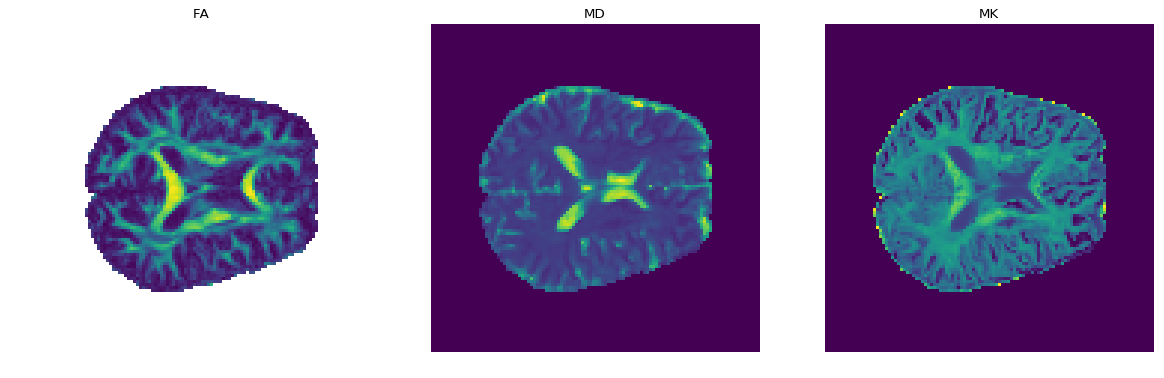

In [15]:
fig = plt.figure(figsize=(18, 16), dpi= 80)
img1 = fig.add_subplot(1,3,1)
img1.imshow(fa[:,:,30]) 
img1.title.set_text('FA')
img1.axis('off')
img2 = fig.add_subplot(1,3,2)
img2.imshow(md[:,:,30])   
img2.title.set_text('MD')
img2.axis('off')
img3 = fig.add_subplot(1,3,3)
img3.imshow(mk_clipped[:,:,30])     
img3.title.set_text('MK')
img3.axis('off')

**Superb!**

## Median Filtering

In [16]:
goodDirs = myimage.goodDirections(outliers)


## Saving Files
Saving these files is easy. With the output folder defined above, all we have to do it call `writeNii` with the correct arguments and call it a day


In [17]:
# mdPath = os.path.join(savePath, 'md.nii')
# rdPath = os.path.join(savePath, 'rd.nii')
# adPath = os.path.join(savePath, 'ad.nii')
# faPath = os.path.join(savePath, 'fa.nii')
# fePath = os.path.join(savePath, 'fe.nii')
# tracePath = os.path.join(savePath, 'trace.nii')
# mkPath = os.path.join(savePath, 'mk.nii')
# rkPath = os.path.join(savePath, 'rk.nii')
# akPath = os.path.join(savePath, 'ak.nii')
# violPath = os.path.join(savePath, 'outliers.nii')
# dirPath = os.path.join(savePath, 'good_directions.nii')

# dp.writeNii(md, dwi.hdr, mdPath)
# dp.writeNii(rd, dwi.hdr, rdPath)
# dp.writeNii(ad, dwi.hdr, adPath)
# dp.writeNii(fa, dwi.hdr, faPath)
# dp.writeNii(fe, dwi.hdr, fePath)
# dp.writeNii(trace, dwi.hdr, tracePath)
# dp.writeNii(mk, dwi.hdr, mkPath)
# dp.writeNii(rk, dwi.hdr, rkPath)
# dp.writeNii(ak, dwi.hdr, akPath)
# dp.writeNii(propviol, dwi.hdr, violPath)
# dp.writeNii(goodDirs, myimage.hdr, dirPath)

## Additional Functions
Saving this functions here so `test_script.py` can be safely removed from `master` branch.

In [18]:
# med = dp.medianFilter(mk, viols, th=1, sz=3, conn='face')
# reps = med.findReplacement(bias='rand')
# md = med.applyReplacement(md)
# rd = med.applyReplacement(rd)
# ad = med.applyReplacement(ad)
# fa = med.applyReplacement(fa)
# mk = med.applyReplacement(rk)
# rk = med.applyReplacement(mk)
# ak = med.applyReplacement(ak)

# dp.writeNii(md, dwi.hdr, mdPath)
# dp.writeNii(rd, dwi.hdr, rdPath)
# dp.writeNii(ad, dwi.hdr, adPath)
# dp.writeNii(fa, dwi.hdr, faPath)
# dp.writeNii(fe, dwi.hdr, fePath)
# dp.writeNii(trace, dwi.hdr, tracePath)
# dp.writeNii(mk, dwi.hdr, mkPath)
# dp.writeNii(rk, dwi.hdr, rkPath)
# dp.writeNii(ak, dwi.hdr, akPath)
# dp.writeNii(propviol, dwi.hdr, violPath)